In [431]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import fiona
import numpy as np
import rasterio
import shapely.geometry as sgeom
import matplotlib as mpl
from rasterio.warp import transform
from rasterio import Affine
from osgeo import osr, gdal, gdal_array
%matplotlib inline

In [432]:
filename = '/home/sagus/Development/wrf-cuenca/src/temp/maps/geotiff/2020_02/06/CBA_A_18_ppn.tif'
wrfout_path = '/home/sagus/Development/temp/wrfout_A_d01_2020-02-06_18:00:00'

In [433]:
CBA_EXTENT = [-68.91031,
              -37.408794,
              -56.489685,
              -27.518177]

WRF_EXTENT = [-538001.0623448786,
              -538000.0000000792,
              537998.9376551214,
              537999.9999999208]

RECORTE_EXTENT = [-66.07031,
                  -35.168794,
                  -61.579685,
                  -29.328177]

KM_PER_DEGREE = 111.32
RESOLUTION = 4

In [434]:
nws_precip_colors = [
    "#ffffff",  # 0.01 - 0.10 inches
    "#04e9e7",  # 0.10 - 0.25 inches
    "#019ff4",  # 0.25 - 0.50 inches
    "#0300f4",  # 0.50 - 0.75 inches
    "#02fd02",  # 0.75 - 1.00 inches
    "#01c501",  # 1.00 - 1.50 inches
    "#008e00",  # 1.50 - 2.00 inches
    "#fdf802",  # 2.00 - 2.50 inches
    "#e5bc00",  # 2.50 - 3.00 inches
    "#fd9500",  # 3.00 - 4.00 inches
    "#fd0000",  # 4.00 - 5.00 inches
    "#d40000",  # 5.00 - 6.00 inches
    "#bc0000",  # 6.00 - 8.00 inches
    "#f800fd",  # 8.00 - 10.00 inches
    "#9854c6"]  # 10.00+
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

In [435]:
def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3], 0, -resy]

In [436]:
def genear_tif_prec(plsm: xr.Dataset, configuracion: str, out_path: str):
    """
    This functions gest a xarray Dataset, gets the vars RAINNC
    and RAINC and saves them as a geotiff tile

    Parameters:
        plsm: path to the wrfout NC file
        out_path: path to the directory where to save
                        the geoptiffs
    """
    try:
        os.makedirs(os.path.dirname(out_path))
    except OSError:
        pass

    arrs = {}
    for t in range(len(plsm.variables['Times'])):
        arrs[t] = (plsm.variables['RAINNC'].values[t, :, :] +
                   plsm.variables['RAINC'].values[t, :, :])

    out_ppn, geoTransform, target_prj = cambiar_projection_ppn(arrs)

    base_path =f"{out_path}{configuracion}_ppn"

    gtiff_id_list = []
    for t in range(1, out_ppn.shape[0]):
        gtiff_id_list.append(guardar_tif.remote(geoTransform, target_prj,
                                                out_ppn[t, :, :] -
                                                out_ppn[t - 1, :, :],
                                                f"{base_path}_{t}.tif"))

    gtiff_id_list.append(guardar_tif.remote(geoTransform, target_prj,
                                            out_ppn[33] - out_ppn[9],
                                            f"{base_path}.tif"))
    gtiff_id_list.append(guardar_tif.remote(geoTransform, target_prj,
                                            out_ppn[45] - out_ppn[9],
                                            f"{base_path}_a36.tif"))
    gtiff_id_list.append(guardar_tif.remote(geoTransform, target_prj,
                                            out_ppn[57] - out_ppn[9],
                                            f"{base_path}_a48.tif"))

    ray.get(gtiff_id_list)

In [437]:
# TodDo: ray to this
def cambiar_projection_ppn(in_array: np.ndarray):
    """Convert Grid to New Projection.
        Parameters
        ----------
        in_array

    """
    # WRF Spatial Reference System
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4('+proj=lcc +lat_0=-32.500008 +lon_0=-62.7 '
                               '+lat_1=-60 +lat_2=-30 +x_0=0 +y_0=0 +R=6370000'
                               ' +units=m +no_defs')
    # Lat/lon WSG84 Spatial Reference System
    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4('+proj=longlat +ellps=WGS84 '
                               '+datum=WGS84 +no_defs')

    # se configura la matriz destino
    sizex = int(((CBA_EXTENT[2] - CBA_EXTENT[0]) * KM_PER_DEGREE) / RESOLUTION)
    sizey = int(((CBA_EXTENT[3] - CBA_EXTENT[1]) * KM_PER_DEGREE) / RESOLUTION)

    out_array = np.ndarray(shape=(len(in_array.keys()), sizey, sizex))

    for t in in_array.keys():
        # loar gdal array y se le asigna la projección y transofrmación
        raw = gdal_array.OpenArray(in_array[t])
        raw.SetProjection(source_prj.ExportToWkt())
        raw.SetGeoTransform(getGeoT(WRF_EXTENT,
                                    raw.RasterYSize,
                                    raw.RasterXSize))

        grid = gdal.GetDriverByName('MEM').Create("tmp_ras",
                                                  sizex, sizey, 1,
                                                  gdal.GDT_Float32)
        # Setup projection and geo-transformation
        grid.SetProjection(target_prj.ExportToWkt())
        grid.SetGeoTransform(getGeoT(CBA_EXTENT,
                                     grid.RasterYSize,
                                     grid.RasterXSize))

        # reprojectamos
        gdal.ReprojectImage(raw,
                            grid,
                            source_prj.ExportToWkt(),
                            target_prj.ExportToWkt(),
                            gdal.GRA_Average,
                            options=['NUM_THREADS=ALL_CPUS'])

        out_array[t] = grid.ReadAsArray()

    return out_array, grid.GetGeoTransform(), grid.GetProjection()

In [438]:
plsm = xr.open_dataset(wrfout_path)

In [439]:
arrs = {}
for t in range(len(plsm.variables['Times'])):
    arrs[t] = (plsm.variables['RAINNC'].values[t, :, :] +
               plsm.variables['RAINC'].values[t, :, :])

In [440]:
out_ppn, geoTransform, target_prj = cambiar_projection_ppn(arrs)

In [441]:
acc = out_ppn[33] - out_ppn[9]

In [450]:
target_prj.

'GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'

In [449]:
plsm

<xarray.Dataset>
Dimensions:                (Time: 58, bottom_top: 34, bottom_top_stag: 35, seed_dim_stag: 2, soil_layers_stag: 4, south_north: 269, south_north_stag: 270, west_east: 269, west_east_stag: 270)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, seed_dim_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    VAR_SSO                (Time, south_north, west_east) float32 ...
    U                      (Time, bottom_top, south_north, west_east_stag) float32 ...
    V                      (Time, bottom_top, south_north_stag, west_east) float32 ...
    W                      (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH                     (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    T                      (Time, bottom_top, south_north, west_east) float32 ...
    THM                    (Time, bottom_top, south_north, west_east) float32 ...
    HFX_FORCE              (Time) float32 ...
    LH_FORCE               (Time) float32 ...
    TSK_FORCE              (Time) float32 ...
    HFX_FORCE_TEND         (Time) float32 ...
    LH_FORCE_TEND          (Time) float32 ...
    TSK_FORCE_TEND         (Time) float32 ...
    MU                     (Time, south_north, west_east) float32 ...
    MUB                    (Time, south_north, west_east) float32 ...
    NEST_POS               (Time, south_north, west_east) float32 ...
    P                      (Time, bottom_top, south_north, west_east) float32 ...
    PB                     (Time, bottom_top, south_north, west_east) float32 ...
    FNM                    (Time, bottom_top) float32 ...
    FNP                    (Time, bottom_top) float32 ...
    RDNW                   (Time, bottom_top) float32 ...
    RDN                    (Time, bottom_top) float32 ...
    DNW                    (Time, bottom_top) float32 ...
    DN                     (Time, bottom_top) float32 ...
    CFN                    (Time) float32 ...
    CFN1                   (Time) float32 ...
    THIS_IS_AN_IDEAL_RUN   (Time) int32 ...
    P_HYD                  (Time, bottom_top, south_north, west_east) float32 ...
    Q2                     (Time, south_north, west_east) float32 ...
    T2                     (Time, south_north, west_east) float32 ...
    TH2                    (Time, south_north, west_east) float32 ...
    PSFC                   (Time, south_north, west_east) float32 ...
    U10                    (Time, south_north, west_east) float32 ...
    V10                    (Time, south_north, west_east) float32 ...
    RDX                    (Time) float32 ...
    RDY                    (Time) float32 ...
    RESM                   (Time) float32 ...
    ZETATOP                (Time) float32 ...
    CF1                    (Time) float32 ...
    CF2                    (Time) float32 ...
    CF3                    (Time) float32 ...
    ITIMESTEP              (Time) int32 ...
    QVAPOR                 (Time, bottom_top, south_north, west_east) float32 .

In [443]:
deltax = -(CBA_EXTENT[0] - CBA_EXTENT[2])/(acc.shape[0]*acc.shape[1])

In [444]:
deltay = -(CBA_EXTENT[1] - CBA_EXTENT[3])/(acc.shape[0]*acc.shape[1])

In [446]:
 #Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = (acc.shape[0],acc.shape[1])
x = np.arange(CBA_EXTENT[0], CBA_EXTENT[2], deltax)
y = np.flip(np.arange(CBA_EXTENT[1], CBA_EXTENT[3], deltay))

# Rasterio works with 1D arrays
lona, lata = transform(plsm.crs, {'init': 'EPSG:4326'}, x, y)
lon = np.asarray(lona).reshape((ny, nx))
lat = np.asarray(lata).reshape((ny, nx))

plsm.coords['lon'] = (('y', 'x'), lon)
plsm.coords['lat'] = (('y', 'x'), lat)

AttributeError: 'Dataset' object has no attribute 'crs'

In [419]:
ya.size

94875

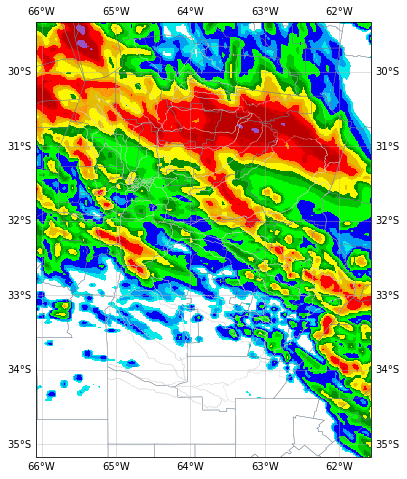

In [454]:
deltax = -(CBA_EXTENT[0] - CBA_EXTENT[2])/(acc.shape[0]*acc.shape[1])
deltay = -(CBA_EXTENT[1] - CBA_EXTENT[3])/(acc.shape[0]*acc.shape[1])

# Compute the lon/lat coordinates with rasterio.warp.transform
nya, nxa = (acc.shape[0],acc.shape[1])
lon = np.arange(CBA_EXTENT[0], CBA_EXTENT[2], deltax)
lat = np.flip(np.arange(CBA_EXTENT[1], CBA_EXTENT[3], deltay))

# Rasterio works with 1D arrays
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

# Plot on a map
plt.figure(figsize=(6, 8), frameon=False)
ax = plt.subplot(projection=ccrs.PlateCarree())

norm = mpl.colors.BoundaryNorm(clevs, len(clevs))

cba_extent = [CBA_EXTENT[0], CBA_EXTENT[2], CBA_EXTENT[1], CBA_EXTENT[3]]
img_plot = ax.imshow(np.flipud(acc), origin='upper', extent=cba_extent,
                     cmap=precip_colormap, norm=norm, transform=ccrs.PlateCarree())

ax.set_extent([RECORTE_EXTENT[0], RECORTE_EXTENT[2], RECORTE_EXTENT[1], RECORTE_EXTENT[3]])
# Abro archivo shapefile con departamentos
shpfile = "../shapefiles/dep.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry'])
                  for shp in records]
# Agrego a la figura cada uno de los departamentos
ax.add_geometries(geometries, ccrs.PlateCarree(),
                  edgecolor='slategrey', facecolor='none', linewidth=0.35)

# Abro archivo shapefile con cuencas
shpfile = "../shapefiles/cuencas.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry'])
                  for shp in records]
# Agrego a la figura cada uno de los departamentos
ax.add_geometries(geometries, ccrs.PlateCarree(),
                  edgecolor='lightgrey', facecolor='none', linewidth=0.2)

ax.coastlines('10m', color='slategrey')

gl = ax.gridlines( draw_labels=True, alpha=0.5)

plt.savefig('test.png', bbox_inches='tight', dpi=160, pad_inches=0)

plt.show()

In [323]:
nx

345

In [279]:
xa.size

345

array([], dtype=float64)

In [190]:
da = xr.open_rasterio(filename)

In [351]:
x, y = np.meshgrid(da['x'], da['y'])

In [352]:
lon, lat = transform(da.crs, {'init': 'EPSG:4326'}, x.flatten(), y.flatten())

[-68.8923090942029,
 -68.8563072826087,
 -68.82030547101449,
 -68.78430365942029,
 -68.74830184782608,
 -68.71230003623188,
 -68.67629822463768,
 -68.64029641304347,
 -68.60429460144927,
 -68.56829278985506,
 -68.53229097826086,
 -68.49628916666666,
 -68.46028735507245,
 -68.42428554347826,
 -68.38828373188406,
 -68.35228192028985,
 -68.31628010869565,
 -68.28027829710145,
 -68.24427648550724,
 -68.20827467391304,
 -68.17227286231883,
 -68.13627105072463,
 -68.10026923913043,
 -68.06426742753622,
 -68.02826561594202,
 -67.99226380434783,
 -67.95626199275362,
 -67.92026018115942,
 -67.88425836956522,
 -67.84825655797101,
 -67.81225474637681,
 -67.7762529347826,
 -67.7402511231884,
 -67.7042493115942,
 -67.66824749999999,
 -67.63224568840579,
 -67.59624387681158,
 -67.56024206521738,
 -67.52424025362319,
 -67.48823844202899,
 -67.45223663043478,
 -67.41623481884058,
 -67.38023300724637,
 -67.34423119565217,
 -67.30822938405797,
 -67.27222757246376,
 -67.23622576086956,
 -67.2002239492753

In [361]:
x.flatten()

array([-68.89230909, -68.85630728, -68.82030547, ..., -56.57968953,
       -56.54368772, -56.50768591])

In [360]:
len(x.flatten())

94875

In [447]:
# Read the data
da = xr.open_rasterio(filename)

In [448]:
da.crs

'+init=epsg:4326'

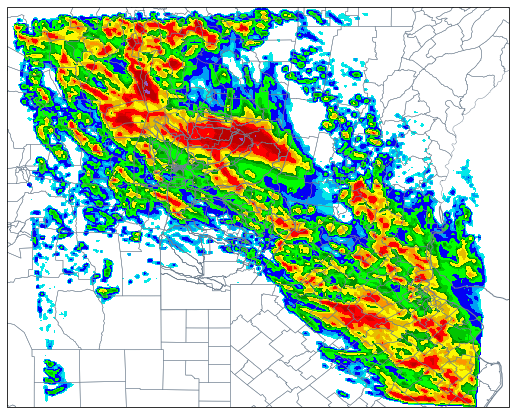

In [392]:

# Read the data
da = xr.open_rasterio(filename)

# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

# Compute a greyscale out of the rgb image
greyscale = da[0, :, :]

# Plot on a map
plt.figure(figsize=(9, 12), frameon=False)
ax = plt.subplot(projection=ccrs.PlateCarree())
clevs = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 30, 40, 50, 80, 100, 200, 300]
norm = mpl.colors.BoundaryNorm(clevs, precip_colormap.N)

cba_extent = [CBA_EXTENT[0], CBA_EXTENT[2], CBA_EXTENT[1], CBA_EXTENT[3]]
img_plot = ax.imshow(greyscale,origin='upper', extent=cba_extent,
                     cmap=precip_colormap, norm=norm, transform=ccrs.PlateCarree())

# Abro archivo shapefile con departamentos
shpfile = "../shapefiles/dep.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry'])
                  for shp in records]
# Agrego a la figura cada uno de los departamentos
ax.add_geometries(geometries, ccrs.PlateCarree(),
                  edgecolor='slategrey', facecolor='none', linewidth=0.45)

# Abro archivo shapefile con cuencas
shpfile = "../shapefiles/cuencas.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry'])
                  for shp in records]
# Agrego a la figura cada uno de los departamentos
ax.add_geometries(geometries, ccrs.PlateCarree(),
                  edgecolor='slategrey', facecolor='none', linewidth=0.45)

ax.coastlines('10m', color='slategrey')

plt.savefig('test.png', bbox_inches='tight', dpi=160)
plt.show()
